# From social science to Data science

So this is my showcase of skills in Data Science. This code compilation is mine but I have to give credit to Sentdex, the youtuber who has been a great resource for anyone that wants to learn to use Python.

This portfolio is meant to showcase some good coding convention, analytical "know-how" and communication skills of rather complex materials.

For this particular portfolio I will calculate the returns and volatility for thousands of randomly generated portfolios. To make it interesting I will use companies listed in the S&P500 index. 

First let me give a rough outline of the first few code blocks.

1. Import all libraries I think I might need
2. Create a function/webscraper to get the tickers for all companies within the S&P500
3. Download all the data from yahoo and export into a company specific csv file
4. Create a joined data frame using the ticker name as the column header and Adjusted close price as the row values. The date will be the index.
5. Create randomly generated portfolios and calculate the volatility to find which size portfolios will generated the most acceptable level of volatility
6. Create randomly generated portfolios using the size of portfolios from step 5 and find the optimal assets and weights for those assets.
7. Show the optimal portfolio in this case. 

I think that there is some disclaimers that need to said. These portfolios are randomly generated, so these are not necessarily the absolute best or optimized, but would represent a rather good estimation portfolio given the data.

Lets get to it!

In [1]:
import bs4 as bs
import datetime as dt
import random
import os
import pandas_datareader.data as web
import pandas as pd
import pickle
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from pandas.core.common import flatten


<br>
Here below we see an example of a bad function. It will return 500 lists within a single list, so *I recommend not using this*, but I like keeping this here to recognize (and remind me/others) that although some code looks good and does what its should, the output may be in a format that is unpractical moving forward. Sometimes simple is better and in this case we are seeing a aspect of that, where a solution that looks complex is bad. See the next function, which is a lot better then this. 

<br>

In [ ]:
def save_sp500_tickers():
    '''
    This will open up the wikipedi for S&P500 index and webscrape the 
    tickers for all companies in it.
    ###################################################################
    
    This function is not a good one since it returns a list of lists,
    so in purest terms, there are 500 lists within a signel list, which
    is note exactly DS best practice. Lets let his stand as a 
    "What not to do" sort of code example.
    '''
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.split())
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
    
    return tickers


# Uncomment the two lines below to see what the problem with this function is

# a = save_sp500_tickers()
# print(a)

<br>

The code here below does the same function as the code above (like I mentioned above), only better. Its simpler, more elegant and returns just a single list. This is practical and nice. This is a good practice to make sure that the data format is useful moving forward.

<br>

In [ ]:
def save_sp500_tickers():
    '''
    This function will return a list of all tickers listed in the 
    S&P500 index.
    ##############################################################
    
    In regards to the code above, this is simplere and returns a single
    list with all the tickers, making everything down the line simpler.
    '''
    # Use pandas to read the html
    data = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    # Slice the pandas object to where the table is located
    table = data[0]
    #Just a check that everything was working properly
    #table.head()
    
    # set all the tickers to a list
    tickers = table['Symbol'].tolist()
    #print (tickers)
    return tickers

tickers = save_sp500_tickers()

## Downloading the data

Yeah...I set a heading. Reason is that the code block down below is rather intense. What this function get_data_from_yahoo will download data for all the companies listed in the S&P500 and export them to a csv file. Before doing so, you might have to create a directory called stock_dfs in your working directory. This is done to keep the csv separated from other files. Also, why download all and export to csv? Well if I am downloading them anyway I might as well keep them if I want to use the for another project (maybe I will create a SQL database from them? maybe).

<br>
So just before I end this, if you dont want to download huge amounts of data the **DON'T** run the code here below, otherwise go for it. I took the liberty of printing out what data there is in the folder and what is not so it would be easy to notice changes. But...the downside is there are going to be 500 lines of output. Here it could say "Already have ... as csv" if you already have the data, but if you decide to download the data then its going to say "Download complete for ..."

In [ ]:
def get_data_from_yahoo(reload_sp500=False):
    '''
    This will download and export the data for a predetermined date
    for all the tickers in our tickers list.
    ##################################################################
    
    This function, depending on your internet connection, will be very
    heavy, consider decreasing the time frame given here below. 
    '''
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime(2020,3,1)
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker.replace(".", "-"), 'yahoo', start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            #df = df.drop("Symbol", axis=1)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
            print("Download complete for {}".format(ticker))
        else:
            print("Already have {} as a csv".format(ticker))
#get_data_from_yahoo()

<br>

Now I will combine all the 500 data frames into a single data frame, where Adjusted close price will be the only column I will use. The date will be the index and the tickers are the column names.

<br>

In [ ]:
%%time
def compile_data():
    tickers = save_sp500_tickers()
    main_df = pd.DataFrame()
    for count, ticker in enumerate(tickers):
        df = pd.read_csv("stock_dfs/{}.csv".format(ticker))
        df.set_index("Date", inplace = True)

        df.rename(columns = {"Adj Close": ticker}, inplace = True)
        df.drop(["Open", "High", "Low", "Close", "Volume"], 1, inplace = True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how = "outer")

    print(main_df.head())
    main_df.to_csv("sp500_joined_close_price.csv")

#compile_data()

## Calculate random portfolios

So, what if you asked me "How many assets are needed in a portfolio to minimize volatility?". Well lets do that. Well because I am not trying to build the perfect portfolio with weights (that comes later), I just want to know --How many do I need--. So using the dataframe created above, I can now create thousands of random portfolios and see how many assets I need to minimize volatility. 

**Note here**, I am strictly talking about volatility right now, returns and Sharpe ratio (the efficient frontier as well, comes later). 

Lets load up the data and get to work.

In [2]:
df = pd.read_csv("sp500_joined_close_price.csv", parse_dates = ["Date"], index_col = 0)

<br>

Here I run the simulation. It does not take to long to run, but it will generate a random sized portfolio between 1 and 100, which the computer will run 10.000 (ten thousand) times. From there I will plot the volatility and to allow for your own interpretation, lets just eyeball for now what portfolio size you/I think is best.

In [3]:
%%time
random.seed(123)
log_ret = np.log(df/df.shift(1))

# this is the variance, used in the for loop to calculate the volatility
vol = log_ret.std()
# init. empty data frame
results = pd.DataFrame(columns = ["Size", "Return", "Volatility"])
for i in range(10000):
    '''
    In this function we use random module to generate random integers (and list of integers)
    to use along side the pandas .iloc method to get the right subset of randomly generated
    portfolios
    '''
    # random size of portfolio between 1 and 100
    randomsize = random.randint(1, 100)
    # using randomsize to get same amount of random values between 1 and 500
    assets = random.sample(range(0,500), randomsize)
    # picking a random day to sell the position
    randomday = random.sample(range(0,2556), 1)
    # saving the size since that is one of our measures of volatility, i.e more assets = less vol.
    size = len(assets)
    # Calculating the mean return for said portfolio on said day
    mean = log_ret.iloc[randomday, assets].mean(axis = 1)
    # Calculating the std(volatility) for random portfolio 
    std = np.sqrt(vol.iloc[assets].sum())/len(assets)
    #Append the results to the empty data frame
    results = results.append({"Size": size, "Return": mean[0], "Volatility": std}, ignore_index = True)
# df can be used for further ploting or calculation
df2 = results.sort_values(by = "Size", ascending = False)
# This is the answer to part 1, use for plotting and to generate describtive statistics
df2 = df2.groupby('Size').mean()

Wall time: 28.2 s


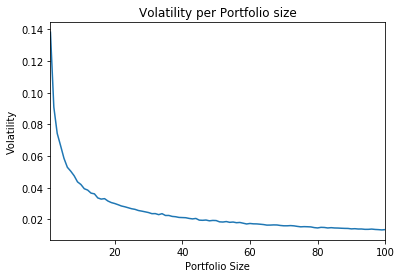

In [4]:
df2["Volatility"].plot()
plt.title("Volatility per Portfolio size")
plt.xlabel("Portfolio Size")
plt.ylabel("Volatility")
plt.show()

I think that this plot speaks for itself. I chose the number 20, I think having 20 assets in a portfolio is a good volatility number to accept. 

So lets take this to the next step, lets try and add some weights to these portfolios, except now lets fix the portfolio sizes to 20 assets. I realize this might (very likely will) impact the outcome in such a way that the calculations above have no relation to this one. That being said, those portfolios are randomly selected and only measure in a naive the volatility. 

As an added bonus lets try and find the best asset combinations to have in a portfolio. Its a bit trickier but very well doable. 

Lets get started.

In [5]:
%%time
random.seed(123)
log_ret = np.log(df/df.shift(1))

# this is the variance, used in the for loop to calculate the volatility
vol = log_ret.std()
# init. empty data frame
results20 = pd.DataFrame(columns = ["Size", "Return", "Volatility"])
names = []
weightlist = []
for i in range(10000):
    '''
    In this function we use random module to generate random integers (and list of integers)
    to use along side the pandas .iloc method to get the right subset of randomly generated
    portfolios
    '''
    weights = np.random.random(20)  
    weights /= np.sum(weights)
    weightlist.append(weights)
    # size of portfolio is now fixed at 20
    size = 20
    # using randomsize to get same amount of random values between 1 and 500
    assets = random.sample(range(500), size)
    # picking a random day to sell the position
    randomday = random.sample(range(0,2556), 1)
    # Calculating the mean return for said portfolio on said day
    mean = log_ret.iloc[randomday, assets].mean(axis = 1)
    # Calculating the std(volatility) for random portfolio 
    std = np.sqrt(vol.iloc[assets].sum())/len(assets)
    names.append(log_ret.iloc[randomday, assets].columns.values)
    #Append the results to the empty data frame
    results20 = results20.append({"Size": size, "Return": mean[0], "Volatility": std}, ignore_index = True)

Wall time: 35.4 s


In [7]:
print("The highest return portfolio")
print(results20.sort_values(by = "Return", ascending = False).head(1))
print("")
print("List of the assets in the portfolio")
print(names[9256])
print("")
print("The weights for each asset in same order as the assets")
print(weightlist[9256])

The highest return portfolio
      Size    Return  Volatility
9256  20.0  0.182271    0.049056

List of the assets in the portfolio
['CVS' 'XOM' 'BKNG' 'MGM' 'CTL' 'IRM' 'NWSA' 'HON' 'EA' 'EQR' 'PEG' 'CAG'
 'NLSN' 'GOOGL' 'LEG' 'MTB' 'TROW' 'TT' 'J' 'CE']

The weights for each asset in same order as the assets
[0.0334089  0.03874708 0.06706916 0.03255073 0.04824048 0.04813469
 0.05479863 0.0582607  0.07561097 0.05335559 0.04289949 0.07699641
 0.03892566 0.06299288 0.05690659 0.0715864  0.02559207 0.04672883
 0.00881801 0.05837672]


## Next steps ???

Although this looks good there are certain things that need to be taken into consideration. I did not calculate the Sharpe Ratio or Information ratio for the portfolios. Also worth noting, I did not annualize the returns, something that can easily be fixed, but the results would not change much from where we stand now. Also on my to-do list is to visualize the Sharpe Ratio and the efficient frontier, not only because its cool, it does give good information about what type of portfolio one should create thats depended on a persons risk-aversion.

For now lets let this stand for what it is...a good start.